## Confidence Intervals for xG values

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from tqdm import tqdm

In [2]:
def get_angle(b):
    b = np.array(b)
    a = np.array([100,45])
    c = np.array([100,55])
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/sharmaabhishekk/undershot_backup/master/understat_all_shots.csv")  

In [4]:
df.head()

,X,Y,a_goals,a_team,date,h_a,h_goals,h_team,id,lastAction,match_id,minute,player,player_assisted,player_id,result,season,shotType,situation,xG
0,0.707,0.379,0,Hoffenheim,29-08-2015 17:30,h,0,Darmstadt,76737,Aerial,1044,93,György Garics,NaN,2,MissedShots,2015,RightFoot,FromCorner,0.011869
1,0.728,0.373,1,Darmstadt,12-09-2015 17:30,a,0,Bayer Leverkusen,76808,Pass,1053,1,György Garics,Konstantin Rausch,2,SavedShot,2015,RightFoot,SetPiece,0.015980
2,0.016,0.464,0,Darmstadt,01-11-2015 18:30,a,2,VfB Stuttgart,78492,Foul,1118,67,György Garics,NaN,2,OwnGoal,2015,Head,SetPiece,0.000000
3,0.875,0.521,2,Darmstadt,20-12-2015 20:30,a,3,Borussia M.Gladbach,79876,Aerial,1173,58,György Garics,NaN,2,MissedShots,2015,Head,FromCorner,0.016684
4,0.927,0.557,2,Werder Bremen,07-12-2014 16:30,a,5,Eintracht Frankfurt,27374,Pass,5320,78,Luca Caldirola,Fin Bartels,3,Goal,2014,LeftFoot,OpenPlay,0.432700


In [5]:
##Some cleaning

##Remove set-pieces (corners, pens, direct freekicks) for simplicity's sake
##Remove headers
##Remove own-goals (opted to keep blocked shots though)
##Convert to Opta/WhoScored 100x100 pitch coordinates

df = df.loc[(df["shotType"].isin(["RightFoot", "Leftfoot", "Head"])) &\
            (df["result"] != "OwnGoal") & (df["situation"] == "OpenPlay")].reset_index(drop=True) 
df[["X", "Y"]] = df[["X", "Y"]]*100
df["goal_x"] = 100
df["goal_y"] = 50
df["length"] = np.sqrt( np.square(df["goal_x"] - df["X"]) + np.square(df["goal_y"] - df["Y"]) )
df["angle"] = df[["X", "Y"]].apply(get_angle, axis=1)
df = df[["X", "Y", "length", "angle", "shotType", "result"]]

In [7]:
##Encoding categorical values

results_dict = {"MissedShots":0, "SavedShot":0, "BlockedShot":0, "ShotOnPost":0, "Goal":1}
df["result"] = df["result"].map(results_dict)

shot_type_dict = {"RightFoot": 1,
                 "LeftFoot": 1,
                 "Head": 0}
df["shotType"] = df["shotType"].map(shot_type_dict)
df.head()


,X,Y,length,angle,shotType,result
0,91.699997,53.000000,8.825534,57.493519,0,0
1,91.199997,61.200001,14.243598,26.322316,0,0
2,88.599998,54.599999,12.293088,42.110460,1,0
3,87.800003,56.299999,13.730620,36.724436,1,0
4,87.500000,62.700001,17.819653,23.136629,1,1


You might want to one-hot encode the shotType and result but for the purpose of this, I've decided to leave it be

In [8]:
y = df["result"].to_numpy()
X = df.drop("result", axis=1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=314)

In [15]:
%%time

num = 100 ##100 runs take around 30 minutes on my prehistoric laptop
model = XGBClassifier() ##feel free to mess around with the hyperparameters
total_xg_vals = []
for _ in tqdm(range(num)):
    n = int(.4*X_train.shape[0])  # get random 40% of the data every epoch
    index = np.random.choice(X_train.shape[0], n, replace=False)  

    X_train_ = X_train[index]
    y_train_ = y_train[index]
    
    model.fit(X_train_, y_train_) ##train model on the bootstrapped data
    
    xg_vals = [p[1] for p in model.predict_proba(X_test)]
    total_xg_vals.append(xg_vals)
    
    

100%|████████████████████████████████████| 100/100 [27:09<00:00, 16.29s/it]

Wall time: 27min 9s


In [16]:
total_xg_vals = np.array(total_xg_vals)
total_xg_vals.shape

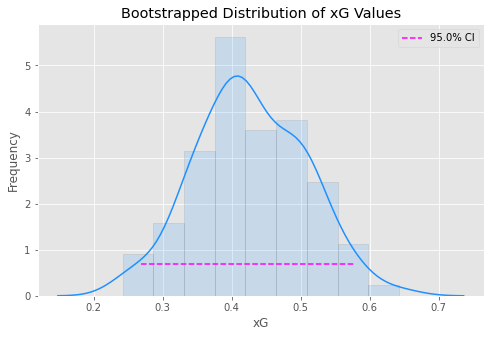

In [53]:
import seaborn as sns
plt.style.use("fast")

fig, ax = plt.subplots(figsize=(8,5))
##vizualize a single shot's xg values (index=2500)
sns.distplot(total_xg_vals[:, 2500], color="dodgerblue", ax = ax, hist_kws={"density": True, "alpha":.15,
                                                                           "color":"dodgerblue", 
                                                                           "ec":"k"})

alpha = 5.0 ##95% confidence interval
lower_p = alpha / 2.0
lower = max(0.0, np.percentile(total_xg_vals[:, 2500], lower_p))

upper_p = (100 - alpha) + (alpha / 2.0)
upper = min(1.0, np.percentile(total_xg_vals[:, 2500], upper_p))

ax.plot([lower, upper], [.7]*2, label=f"{100-alpha}% CI", color="magenta", lw=1.5, linestyle="--")
ax.set(xlabel="xG", ylabel="Frequency", title="Bootstrapped Distribution of xG Values")
ax.legend();
fig.savefig("bootstrapped_xg", dpi=150)
